<a href="https://colab.research.google.com/github/jugernaut/Induccion_MeIA/blob/angel/5_IntroduccionAP/03_RedesMulticapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Multicapa

Redes Multicapa</a> by <span property="cc:attributionName">Miguel Angel Pérez León</span> is licensed under <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/?ref=chooser-v1" target="_blank" rel="license noopener noreferrer" style="display:inline-block;">CC BY-NC-SA 4.0<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/nc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a></p>

# Introducción

Este material se generó con base en los videos e ideas que se muestran en las referencias, para mayor detalle es necesario consultar las mismas.

# Planteamiento del problema

Vamos a generar una red neuronal que nos ayude a clasificar un conjunto de datos.

Para hacerlo un poco más interesante, pensemos que lo que estamos buscando es rescatar a los héroes de *Game of Thrones*, para ver un poco más de detalles al respecto visitar este [video](https://youtu.be/uwbHOpp9xkc?t=437).

La idea básica es encontrar una forma de delimitar a los datos de color salmón y los datos de color azul, de manera gráfica veríamos lo siguiente.

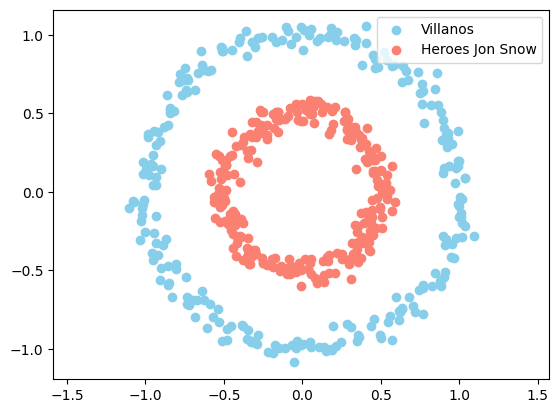

In [2]:
# import de las bibliotecas necesarias
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# numero de muestras
n = 500
# tipo de datos
p = 2

# x=coordeadas, y=valores (adentro o fuera)
x, y = make_circles(n_samples=n, factor=0.5, noise=0.05)
y = y[:, np.newaxis]

# se grafican ambos conjuntos de datos
plt.scatter(x[y[:,0]==0 ,0], x[y[:,0]==0 ,1], c='skyblue', label="Villanos")
plt.scatter(x[y[:,0]==1, 0], x[y[:,0]==1 ,1], c='salmon', label="Heroes Jon Snow")
plt.legend()
plt.axis("equal")
plt.show()

Imaginemos que los datos de color azul son los "enemigos" y los datos de color salmón son los "aliados".

Necesitamos definir un algoritmo que nos ayude a determinar si un par de coordenadas $(x, y)$ corresponden a un **aliado** ó a un **enemigo**.

Para tal propósito vamos a crear una red neuronal que nos ayude a clasificar a estos individuos.

# POO (paradigma orientado a objetos)

Para una mejor organización de los algoritmos que se mostrarán a continuación, lo mejor es hacer uso del paradigma orientado a objetos. De tal forma que vamos a crear la clase `CapaNeuronal`, dentro de la clase `RedNeuronal`.

Además vamos a definir el **comportamiento** y **caracteristicas** de cada clase.

In [3]:
# Clase para crear redes neuronales
class RedNeuronal(object):
    '''
    Constructor de redes neuronales, usa capas y funcion de act
    top:    topologia de la red, la cantidad de neuronas
            y de conexiones que existe entre cada capa
    act_f:  funcion de activacion para la red, misma que se aplica
            en cada capa
    ejemplo: topologia = [p, 4, 8, 1], la primera capa tiene p
    neuronas, la segunda 4 y asi hasta llegar a 1 salida de la red
    '''
    def __init__(self, top, act_f):
        # capas de la red neuronal
        capas = []
        # por cada capa en la topologia se crea una objeto de tipo capa
        for c in range(len(top[:-1])):
            capas.append(RedNeuronal.CapaNeuronal(top[c], top[c+1], act_f))

        self.capas = capas
        self.topologia = top
        self.fun_act = act_f

    # Define una estructura para una capa de la red
    class CapaNeuronal():
        '''
        constructor
        n_conn: numero de conexiones entre las neuronas
        n_neur: numero de neuronas en la capa
        act_f:  funcion de activacion para esta capa
        '''
        def __init__(self, n_conn, n_neur, act_f):
            self.act_f = act_f
            # bias para cada entrada de las neuronas
            # se multiplica por 2 y se resta menos 1 para moverlo al rango adecuado
            self.b = np.random.rand(1, n_neur) * 2 -1
            # matriz de pesos asociados a las neuronas por capa
            self.w = np.random.rand(n_conn, n_neur) * 2 -1

    '''
    Metodo que implemeta el entrenamiento (y prediccion) de la red neuronal
    hace uso del forward pass, backward pass y gradient descend
    x: valores de entrenamiento (o prediccion)
    y: valores esperados en caso de entrenamiento
    f_costo: funcion de costo para el proceso de aprendizaje
    aprendizaje: tasa de aprendizaje, que tanto se modifican los parametros
    etrenar: modo entrenamiento o prediccion
    '''
    def entrenamiento(self, x, y=None, f_costo=None, aprendizaje = 0.5, entrenar=True):
        # salidas de la red por cada capa, se alamacena la suma ponderada
        # y la salida de la funcion de activacion (z, a)
        salidas = [(None, x)]
        # variable temporal para no sobreescribir y poder actualizar los pesos
        _w = None
        # para cada capa de la red
        for capa in self.capas:
            # paso hacia adelante, vector de entrada pasa capa por capa
            '''Por cada capa se multiplica la ultima salida (salidas[-1][1] o input)
            por la matriz de pesos de la capa (capa.w) y al resultado se le suma
            el vector bias (capa.bias). De esta forma en z se almacena la suma
            ponderada (z) de toda un capa en forma de vector columa'''
            z = np.matmul(salidas[-1][1], capa.w) + capa.b
            '''La suma ponderada z se pasa por la funcion de activacion para obtener
            el vector columna de salida de la capa actual, eso se almacena en la
            variable a'''
            a = capa.act_f[0](z)
            salidas.append((z, a))
        # en caso de entrenar a la red es necesario realizar BACKPROPAGATION
        if entrenar:
            # vector que almacena las modificaciones a realizar en los parametros w
            # VER VIDEO DE FORMULAS
            deltas =[]
            # comenzamos del final y vamos hacia el inicio (reversed)
            for c in reversed(range(len(self.capas))):
                z = salidas[c+1][0]
                a = salidas[c+1][1]

                if c == len(self.capas) - 1:
                    #calcular delta ultima capa (revisar video deltas)
                    deltas.insert(0, f_costo[1](a, y) * self.capas[c].act_f[1](a))
                else:
                    #calcular resto de las deltas (revisar video deltas)
                    deltas.insert(0, deltas[0] @ _w.T * self.capas[c].act_f[1](a))

                #variable temporal para no sobreescribir
                _w = self.capas[c].w
                #DESCENSO DEL GRADIENTE
                self.capas[c].b = self.capas[c].b - np.mean(deltas[0],
                                        axis=0, keepdims=True) * aprendizaje
                self.capas[c].w = self.capas[c].w - salidas[c][1].T @ deltas[0] * aprendizaje
        # se devuelve la salida de la última capa
        return salidas[-1][1]


## Clase `CapaNeuronal`

Esta clase nos proporciona la estructura de datos para almacenar y representar los componentes de la red.

Pensemos en esta clase como la clase que nos ayuda a **abstraer y condensar las caractetisticas** que nos interesan de una capa de la red neuronal.

Algunas de estas caracteristicas, serían elementos como:

*   Número de nueronas.
*   Matriz de pesos de las conexiones que entran en cada neurona.
*   Valores de los sesgos por cada neurona.
*   Función de activación.

De tal forma que podemos imaginar que esta clase se ve de la siguiente manera.

<center>
<img src="https://github.com/jugernaut/ProgramacionEnParalelo/blob/desarrollo/Imagenes/RedesNeuronales/Capa.png?raw=1" width="400">
</center>

En términos matemáticos podemos pensar que en cada capa se almacenan los elementos necesarios para realizar la suma ponderada y mediante la función de activación determinar el estado de las neuronas de la capa en cuestión.

## Activaciones (entradas)

Las activaciones o entradas no pertenece propiamente a la clase `CapaNeuronal` pero son parte de los elementos que se usan para el calculo de las activaciones, así que es buena idea comenzar a darle una notación.

Pensemos que organizamos las activaciones (o entradas en el caso de la capa de entrada) en un vector columna, digamos $\vec{a}$.

Para una mejor organización, usemos un superindice para señalar la capa a la que que pertenecen estan activaciones y un subindice para indicar el renglón al que pertenece dicha activación, es decir $a_{i}^{c}$.

En forma matricial estos elementos (correspondientes a la capa de entrada, como se muestra en la imagen) se verían de la siguiente forma.

$$\begin{array}{ccc}
a^{1} & = & \left(\begin{array}{c}
a_{1}^{1}\\
a_{2}^{1}
\end{array}\right)\end{array}$$

### Pesos $(w)$

Todos los pesos los podemos agrupar en una matriz, en la cual cada renglon $i$ contiene los pesos asociados a las conexiones entre la neurona $i$ y las salidas de la capa anterior, es decir entre la capa $c-1$ y la capa $c$.

Esta matriz de pesos (entre la capa de entrada y la siguiente capa) se veria de la siguiente forma.

$$W=\left(\begin{array}{cc}
w_{1,1} & w_{1,2}\\
w_{2,1} & w_{2,2}\\
\vdots & \vdots\\
w_{n,1} & w_{n,2}
\end{array}\right)$$

### Sesgos $(b)$

El vector de sesgos toma una forma similar a las activaciones, es decir.

$$\begin{array}{ccc}
b^{1} & = & \left(\begin{array}{c}
b_{0}^{1}\\
b_{1}^{1}\\
\vdots\\
b_{n}^{1}
\end{array}\right)\end{array}$$

Para el caso del vector de sesgos comenzamos con el superindice 1, ya que la capa de entrada no contiene un vector de sesgos.

### Notación matricial

Ya que contamos con estos elementos es muy sencillo expresar todas los operaciones que se llevan a cabo en una capa cuando se realiza el paso hacia adelante (*forward pass*).

Recordando un poco este proceso del paso hacia adelante, es necesario tener en mente las siguientes operaciones.

1.   Multiplicaciones de pesos y activaciones (o entradas).
2.   Suma ponderada.
3.   Suma del sesgo.
4.   Hacer uso de la función de activación para cada neurona de la capa.

En forma compacta podemos pensar en todas estas operaciones (entre la capa de entrada y la primer capa oculta *Layer* en inglés) de la siguiente forma.

$$\begin{array}{cccccc}
\left(\begin{array}{cc}
w_{1,1} & w_{1,2}\\
w_{2,1} & w_{2,2}\\
\vdots & \vdots\\
w_{n,1} & w_{n,2}
\end{array}\right) & \left(\begin{array}{c}
a_{1}^{L-1}\\
a_{2}^{L-1}
\end{array}\right) & + & \left(\begin{array}{c}
b_{1}^{L}\\
b_{2}^{L}\\
\vdots\\
b_{n}^{L}
\end{array}\right) & = & \left(\begin{array}{c}
a_{1}^{L-1}*w_{1,1}+a_{2}^{L-1}*w_{1,2}+b_{1}^{L}\\
a_{1}^{L-1}*w_{2,1}+a_{2}^{L-1}*w_{2,2}+b_{2}^{L}\\
\vdots\\
a_{1}^{L-1}*w_{n,1}+a_{2}^{L-1}*w_{n,2}+b_{n}^{L}
\end{array}\right)\end{array}$$

Finalmente dado que el resultado es un vector columa, podemos usar este vector y pasarlo por la función de activación para determinar el estado de cada neurona de la capa en cuestión, es decir.

$$F\left(\vec{X}\right)$$

En este [video](https://youtu.be/jKCQsndqEGQ?t=897) puedes encontrar una expliación más detallada de esta notación.

La siguiente celda se muestra el ejemplo de una sola `CapaNeuronal` que contiene **4 neuronas** y cada una de estas neuronas **se conecta con 3 neuronas de la capa previa**, es decir una matriz de $3\times4$.

A su vez también esta capa almacena el vecto de sesgos (*bias*), que en notación matricial corresponde a una matriz de $1\times4$. Posteriormente **se realizan las transpuestas** de estos vectores para poder realizar las operaciones matriciales necesarias.

No se recibe función de activación ya que la intención de esta celda es solo mostrar la estructura de cada capa.

In [4]:
capa = RedNeuronal.CapaNeuronal(3, 4, None)
# matiz de pesos de las conecciones con las neuronas
print(capa.w.T)
# vector columna que forma parte de la suma ponderada
print(capa.b.T)

[[-0.04460881 -0.10717081  0.0815793 ]
 [-0.42904495  0.99362895 -0.70322724]
 [ 0.02240216  0.81068574 -0.0808062 ]
 [ 0.4673962  -0.54540007 -0.47016755]]
[[-0.40752283]
 [-0.22482625]
 [-0.78158377]
 [ 0.75804609]]


## Clase `RedNeuronal`

Esta clase reune todas las características que nos interesa modelar de una red neuronal ya que en su interior hace uso de capas (`CapaNeuronal`) para modelar la estructura de una red neuronal, además del comportamiento de la misma.

La clase `RedNeuronal` encapsula a la clase `CapaNeuronal`, ya que como es costumbre en el POO, las clases que se construyen como en este caso (o la clase lista y nodo) normalmente son definidas de forma anidada.

Incluso tú podrías definir la clase `Neurona` como la definimos previamente y con base en esta clase crear las capas de la red neuronal.



## Constructor

El constructor de la clase `RedNeuronal` recibe como parametros una **lista que contiene el número de neuronas por cada capa** y también la **función de activación** que será aplicada a todas las capa de la red, en la siguiente celda solo se muestra la estructura de la red, así que no es necesario definir la función de activación, es por eso que usa el parámetro `None`.

Por cada elemento en la lista (`topologia`) se genera un objeto de la clase `CapaNeuronal` que contiene el número de neuronas y la función de activación. Esta lista de capas, así como la topología y la función de activación se almacenan como **atributos de la clase** `RedNeuronal`.

Veamos un ejemplo de un objeto de tipo `RedNeuronal`.

In [5]:
# topologia de la red
topologia = [2, 4, 8, 1]

# creamos un objeto de tipo RedNeuronal sin funcion de activacion
red = RedNeuronal(topologia, None)

# tenemos 3 capas ya que la primera (entrada), no se considera
print(red.capas)
# primer capa, 2 conexiones y 4 neuronas
print(red.capas[0], red.capas[0].w.shape)
# segunda capa, 4 conexiones y 8 neuronas
print(red.capas[1], red.capas[1].w.shape)
# tercer capa, 8 conexiones y 1 neurona
print(red.capas[2], red.capas[2].w.shape)


[<__main__.RedNeuronal.CapaNeuronal object at 0x7efec0547070>, <__main__.RedNeuronal.CapaNeuronal object at 0x7efec0546770>, <__main__.RedNeuronal.CapaNeuronal object at 0x7efec05466b0>]
<__main__.RedNeuronal.CapaNeuronal object at 0x7efec0547070> (2, 4)
<__main__.RedNeuronal.CapaNeuronal object at 0x7efec0546770> (4, 8)
<__main__.RedNeuronal.CapaNeuronal object at 0x7efec05466b0> (8, 1)


## Entrenamieto

El método `entrenamiento` tiene 2 formas de operar:

*   `entrenar = False`: en este modo, únicamente se procesa un conjunto de datos de entrada y se devuelve una salida (*forwad pass*).
*   `entrenar = True`: si este modo es seleccionado, la red es entrenada tomando los valores de entrada y las salidas esperadas de la red neuronal.

Si se elige el modo entrenamiento, la red neuronal realiza todos los pasos necesarios para el entrenamiento de la misma:

1.   **Paso hacia adelante**, se toma un elemento de los datos de entrenamiento y se procesa hasta obtener una salida.
2.   **Evaluación de la función de costo**, se evalua la función de costos, tomando la salida esperada y la salida de la red.
3.   **Se calcula el vector gradiente** (descenso del gradiente)
4.   **Se aplica el proceso de retropropagación** del error.


Para tales fines de entrenamiento es necesario calcular un par de derivadas parciales y dado que desde el punto de vista matemático una red neuronal es un conjunto de composición de funciones, es necesario apoyarse un poco en temas de calculo integral y diferencial como, la **regla de la cadena** y **derivadas parciales**.

Para una mayor comprensión de los cálculos realizados en el método de entrenamiento ver este [video](https://youtu.be/M5QHwkkHgAA?t=389).

## Función de activación

En este caso vamos a hacer uso de la función sigmoide y además mediante el mismo identificador de la función vamos a almacenar la derivada de dicha función, ya que se ocupará más adelante.

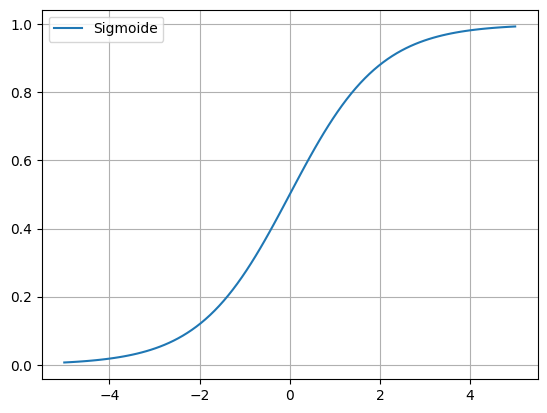

In [6]:
sigm = (lambda x: 1/(1+np.e**(-x)),
        lambda x: x *(1 - x))

_x = np.linspace(-5, 5, 100)

plt.plot(_x, sigm[0](_x), label="Sigmoide")
plt.legend()
plt.grid()
plt.show()

# Ejemplo paso a paso

En esta sección vamos a tratar de mostrar cómo se comportaría una red neuronal si lo hiciéramos a mano para tratar de comprender todo lo que esto involucra, notación, cálculos, conceptos, etc.



## Paso hacia adelante (*forwardpass*)

Vamos a tratar de analizar lo que sucede con los elementos involucrados en el paso hacia adelante (*forward pass*). Para tales fines tomemos como ejemplo una red pequeña conformada por una capa de entrada (2 neuronas), una capa oculta (2 neuronas) y una capa de salida (1 neurona). Si lo vemos en forma de lista las capas de esta red se verían así `[2, 2, 1]`.

Consideremos que esta red es muy sencilla en su forma ya que la intención de esta sección es mostrar cómo se lleva a cabo el paso hacia adelante, pero sucede lo mismo (con más operaciones) con una red más profunda y/o amplia.

Si lo quisiéramos mostrar de manera gráfica, esta red se vería así.

<center>
<img src="https://github.com/jugernaut/Induccion_MeIA/blob/angel/utils/fig/RedNeuronal2.png?raw=1" width="600">
</center>

Nos conviene pensar que por cada capa se tiene una matriz (o vector en caso de ser solo una neurona como la capa $L$ de esta red) de pesos y un vector de sesgos.

### Las capas

Dado que la capa $L-2$ es la capa de entrada podemos pensar que no tiene pesos ni sesgos asociados, sin embargo la capa $L-1$ es la primera que requiere de algunos cálculos para llegar a obtener $a_1$ y $a_2$. En la imágen es un poco complicado agregar todo el detalle que se requiere pero vamos a decir que $a_{1}^{L-1}$ y $a_{2}^{L-1}$ corresponden a los valores de las neuronas de 1 y 2 de la capa $L-1$ respectivamente, veamos ahora cómo se calculan estos valores.

#### Sumas $z$ y activaciones $a$

Para calcular el valor de la neurona 1 de la capa $L-1$, es decir $a_{1}^{L-1}$, necesitamos la suma ponderada $z_{1}^{L-2}$ y esta se calcula de la siguiente manera

$$z_{1}^{L-2}=w_{1,1}^{L-2}x_{1}+w_{1,2}^{L-2}x_{2}+b_{1}^{L-2}$$

Y posteriormente podemos calcular $a_{1}^{L-1}$ de manera muy sencilla

$$a_{1}^{L-1}=f(z_{1}^{L-2})$$

Donde $f$ es la función de activación.

Y de manera muy similar podemos cacular $a_{2}^{L-1}$

$$a_{2}^{L-1}=f(z_{2}^{L-2})=f(w_{2,1}^{L-2}x_{1}+w_{2,2}^{L-2}x_{2}+b_{2}^{L-2})$$


#### Capa $L-2$

Cómo podrás notar son muchos cálculos y si no tenemos cuidado podemos cometer muchos errores, simplemente al momento de organizar los mismos. Pero para ello podemos hacer uso de la notación matricial la cual se ve de la siguiente forma.

$$\begin{array}{cccccccc}
\left(\begin{array}{cc}
w_{1,1}^{L-2} & w_{1,2}^{L-2}\\
w_{2,1}^{L-2} & w_{2,2}^{L-2}
\end{array}\right) & \left(\begin{array}{c}
x_{1}\\
x_{2}
\end{array}\right) & + & \left(\begin{array}{c}
b_{1}^{L-2}\\
b_{2}^{L-2}
\end{array}\right) & = & \left(\begin{array}{c}
w_{1,1}^{L-2}x_{1}+w_{1,2}^{L-2}x_{2}+b_{1}^{L-2}\\
w_{2,1}^{L-2}x_{1}+w_{2,2}^{L-2}x_{2}+b_{2}^{L-2}
\end{array}\right) & = & \left(\begin{array}{c}
z_{1}^{L-2}\\
z_{2}^{L-2}
\end{array}\right)\end{array}$$

Finalmente pasamos a vector $\left(\begin{array}{c}
z_{1}^{L-2}\\
z_{2}^{L-2}
\end{array}\right)$ por la función de activación $f$ y obtenemos las salidas de la primera capa, es decir.

$$\begin{array}{ccc}
\left(\begin{array}{c}
f\left(z_{1}^{L-2}\right)\\
f\left(z_{2}^{L-2}\right)
\end{array}\right) & = & \left(\begin{array}{c}
a_{1}^{L-1}\\
a_{2}^{L-1}
\end{array}\right)\end{array}$$

Es importante notar que **la salida de capa $L-1$ se convierte en la entrada de la capa $L$**.



#### Capa $L-1$

Para calcula la salida de la capa $L$, vamos a necesitar las salidas de la capa $L-1$, de tal manera que ahora las operaciones restantes toman la siguiente forma.

$$z_{1}^{L-1}=w_{1}^{L}a_{1}^{L-1}+w_{2}^{L}a_{2}^{L-1}+b_{1}^{L}$$

Que visto en forma matricial toma la siguiente forma.

$$\begin{array}{cccccc}
\left(\begin{array}{cc}
w_{1}^{L} & w_{2}^{L}\end{array}\right) & \left(\begin{array}{c}
a_{1}^{L-1}\\
a_{2}^{L-1}
\end{array}\right) & + & b_{1}^{L} & = & z_{1}^{L-1}\end{array}$$

Así que.

$$a_{1}^{L}=f(z_{1}^{L-1})$$

Donde, $a_{1}^{L}$ **es la salida de una sola iteración (*forward pass*) de esta red neuronal**.

### Notación vectorial $F(\vec{X})$

A partir de este momento también nos conviene pensar en una red neuronal como una función vectorial que recibe un vector de entradas ($\vec{X}$) y después de una serie de composición de funciones y operaciones matriciales, nos devuelve un resultado.

Para este ejemplo.

$$F:\mathbb{R}^{2}\rightarrow\mathbb{R}$$

Pero no forzosamente tiene que ser así, en general.

$$F:\mathbb{R}^{n}\rightarrow\mathbb{R}^{m}$$

Con $n, m \in \mathbb{N}$.

Regresando al ejemplo veamos algunos detalles importantes.

$$\begin{array}{ccccccccccccc}
F\left(\vec{X}\right) & = & F\left(x_{1},x_{2}\right) & = & \overset{\underbrace{Composici\acute{o}n\,de\,f's}}{f\left(\begin{array}{c}
f\left(z_{1}^{L-2}\right)\\
f\left(z_{2}^{L-2}\right)
\end{array}\right)} & = & f\left(\begin{array}{c}
f\left(w_{1,1}^{L-2}x_{1}+w_{1,2}^{L-2}x_{2}+b_{1}^{L-2}\right)\\
f\left(w_{2,1}^{L-2}x_{1}+w_{2,2}^{L-2}x_{2}+b_{2}^{L-2}\right)
\end{array}\right) & = & f(z_{1}^{L-1}) & = & f\left(w_{1}^{L}a_{1}^{L-1}+w_{2}^{L}a_{2}^{L-1}+b_{1}^{L}\right) & = & a_{1}^{L}\end{array}$$

## Paso hacia atras (*backpropagation*)

Para este punto ya es claro que podemos pensar en una red neuronal como una función $F\left(\vec{X}\right)$ que tiene muchos parámetros (pesos y sesgos) que deben ser "sintonizados" en los valores adecuados para que la red neuronal nos devuelva la salida esperada ($\vec{Y}$) para los datos de entrada ($\vec{X}$).

Además recordemos que la función $F\left(\vec{X}\right)$ está conformada por varias composiciones de funciones más "pequeñas" $f\left(\vec{X}\right)$.

Para saber cuales son los pesos y sesgos ($w,b$) adecuados para el correcto funcionamiento de la red neuronal, vamos a hacer uso de la función de costos y de la regla de la cadena para obtener las derivadas parciales respecto a los pesos y sesgos (por cada neurona) que nos van a llevar a encontrar los pesos y sesgos correctos para minimizar el error en la función de costsos.

### Regla de la cadena

El algoritmo *backpropagation* toma su nombre del hecho de que una vez que realizo el paso hacia adelante, debemos comenzar de la última capa e ir "hacia atrás" para corregir pesos y sesgos en cada neurona a fin de minimizar el error.

Ahora, dado que nuestra $F\left(\vec{X}\right)$ es una composición de funciones, es necesario aplicar la regla de la cadena para poder calcular las respectivas derivadas parciales que nos llevaran a ajustar los pesos y sesgos de forma adecuada.

Sean $f$ y $g$ funciones derivables entonces.

$$f(g(x))'=f'(g(x))g'(x)$$

O en notación de Leibniz, si una variable $z$ (suma ponderada) depende de una variable $y$ y a su vez esta depende de $x$ (esto es $y$ y $z$ son variables dependientes) entonces $z$ también depende de $x$, en tal caso, la regla de la cadena enuncia que.

$$\frac{dz}{dx}=\frac{dz}{dy}\frac{dy}{dx}$$



### Función de Costos

La función de costos es una parte fundamental de toda red neuronal, es la función que nos dice que tan bien o mal se está comportando la red, de acuerdo a los datos de entrenamiento.

Existen muchas funciones de costos (tantas como posibles problemas existen) pero una de las más comunes (y que va a ser usada en este material) es la función conocida como el **error cuadrático medio**.

En palabras, esta función se toma cada una de las salidas de la red y calcula la diferencia entre el dato real, se eleva al cuadrado esta diferencia, se suma y se calcula el promedio.

En términos matemáticos el error cuadrático médio se ve así.

$$C=\frac{1}{N}\sum_{i=1}^{N}(y_{i}-\hat{y}_{i})^{2}$$

Donde $\hat{y}_{i}$ es una de las salidas de la red para la entrada $\vec{x}_{i}$ y $y_{i}$ es un dato real (o esperado) para la entrada $\vec{x}_{i}$.

En el caso más eneral de la función de costos usando el error cuadrático medio, esta puede verse así.

$$||y_i-\hat{y}_i||^{2}_p$$

### Ultima capa ($L$)

Recordemos que para la última capa la suma ponderada en forma de vector se ve de esta forma.

$$z^{L}=w^{L}a^{L-1}+b^{L}$$

Donde $w^{L}$ es la matriz de pesos de la capa $L$ (última capa), $a^{L-1}$ es la salida de la capa anterior y $b^{L}$ es el vector de pesos. Además la salida de la última capa tiene que ser validada con la función de costos, es decir.

$$C\left(a^{L}\left(z^{L}\right)\right)=\frac{1}{N}\sum_{i=1}^{N}(y_{i}-a^{L}\left(z^{L}\right)_{i})^{2}$$

Por lo que, para calcular la derivada de la función de costo respecto a los pesos y a los sesgos, debemos aplicar la regla de la cadena para obtener las siguientes expresiones.

Derivada de la función de costo respecto a los pesos $(w)$.

$$\frac{\partial C}{\partial w^{L}}=\frac{\partial C}{\partial a^{L}}\frac{\partial a^{L}}{\partial z^{L}}\frac{\partial z^{L}}{\partial w^{L}} \tag{1}$$

Derivada de la función de costo respecto a los sesgos $(b)$.

$$\frac{\partial C}{\partial b^{L}}=\frac{\partial C}{\partial a^{L}}\frac{\partial a^{L}}{\partial z^{L}}\frac{\partial z^{L}}{\partial b^{L}} \tag{2}$$






#### Derivada $\frac{\partial C}{\partial a^{L}}$

Parecerína derivadas muy complicadas pero veamos $\frac{\partial C}{\partial a^{L}}$, esta expresión nos pide ver como cambia la función de costos respecto a la salida de la última capa de la red y eso se calcula de la siguiente manera.

Dado que en esta red (de este ejemplo) solo se tiene una neurona en la capa de saldia, entonces la función de costos en la última capa se aplica así.

$$C\left(a_{1}^{L}\right)=\frac{1}{2}\sum_{i=1}^{1}(y_{1}-a_{1}^{L})^{2}=\frac{1}{2}\left(y_{1}-a_{1}^{L}\right)^{2}=\frac{1}{2}\left(y_{1}^{2}-2y_{1}a_{1}^{L}+\left(a_{1}^{L}\right)^{2}\right)=\frac{y_{1}^{2}}{2}-y_{1}a_{1}^{L}+\frac{\left(a_{1}^{L}\right)^{2}}{2}$$

Y por lo tanto la derivada de la función de costos respecto a la salida de la última capa sería.

$$\frac{\partial C}{\partial a_{1}^{L}}=\left(a_{1}^{L}-y_{1}\right)$$

#### Derivada $\frac{\partial a^{L}}{\partial z^{L}}$

Este derivada indica como varia la salida de la ultima capa respecto a la suma ponderada de la última capa, si estuvieramos usando la función de activación sigmoide, es decir.

$$a^{L}\left(z^{L}\right)=\frac{1}{\left(1+e^{\left(z^{L}\right)}\right)}$$

Entonces.

$$\frac{\partial a^{L}}{\partial z^{L}}=a^{L}\left(z^{L}\right)\left(1-a^{L}\left(z^{L}\right)\right)$$


#### Derivada $\frac{\partial z^{L}}{\partial w^{L}}$ y $\frac{\partial z^{L}}{\partial b^{L}}$

Finalmente solo necesitamos calcular las parciales de la suma ponderada $(z)$, respecto a los pesos y sesgo $(w,b)$

Veamos, dado que el sesgo es un término independiente, entonces.

$$\frac{\partial z^{L}}{\partial b^{L}}=1$$

Y por otro lado, ya que $w$ tiene como factor en la suma ponderada a la activación de la capa anterior, entonces.

$$\frac{\partial z^{L}}{\partial w^{L}}=a_{i}^{L-1}$$

#### Delta

En $(1)$ y $(2)$, podemos notar que hay un término que se repite, este termino es.

$$\frac{\partial C}{\partial a^{L}}\frac{\partial a^{L}}{\partial z^{L}} \tag{3}$$

Este término nos dice cómo varía la función de costos respecto a la suma ponderada, en otras palabras que tan culpable es esa neurona del resultado final, normalmente a este término se le conoce como delta, es decir.

$$\delta^{L}=\frac{\partial C}{\partial a^{L}}\frac{\partial a^{L}}{\partial z^{L}}$$



#### Finalmente

Así que finalmente podemos reestructurar $(1)$ y $(2)$ para ajustar los pesos y sesgos de la última capa mediante las expresiones.

$$\frac{\partial C}{\partial w^{L}}=\delta^{L}a_{i}^{L-1}$$

Y para los sesgos.

$$\frac{\partial C}{\partial b^{L}}=\delta^{L}$$


### Resto de capas ($L-i$)

Parecen muchas derivadas y aún faltan unas cuantas, sin embargo lo bueno del algoritmo *backpropagation* es que los cálculos que hagamos para esta capa se puede aplicar para el resto de capas restantes. Así que solo debemos agregar un par de derivadas parciales a $(1)$ y $(2)$, que ahora se verán así.

#### $\frac{\partial C}{\partial w^{L-1}}$ y $\frac{\partial C}{\partial b^{L-1}}$

Para el resto de capas $L-i$ las derivadas respecto a los pesos y sesgos se ven así

$$\frac{\partial C}{\partial w^{L-1}}=\frac{\partial C}{\partial a^{L}}\frac{\partial a^{L}}{\partial z^{L}}\frac{\partial z^{L}}{\partial a^{L-1}}\frac{\partial a^{L-1}}{\partial z^{L-1}}\frac{\partial z^{L-1}}{\partial w^{L-1}} \tag{3}$$

Derivada de la función de costo respecto a los sesgos $(b)$.

$$\frac{\partial C}{\partial b^{L-1}}=\frac{\partial C}{\partial a^{L}}\frac{\partial a^{L}}{\partial z^{L}}\frac{\partial z^{L}}{\partial a^{L-1}}\frac{\partial a^{L-1}}{\partial z^{L-1}}\frac{\partial z^{L-1}}{\partial b^{L-1}} \tag{4}$$

En principio parecen muchas derivadas pero si te fijas, cási todos los términos ya fueron calculados en la capa previa, el único término nuevo es.

$$\frac{\partial z^{L}}{\partial a^{L-1}} \tag{5}$$

Esta derivada $(5)$ nos cuenta como cambia la suma ponderada de una capa si se modifica la salida de la capa previa y en escencia es la matríz de pesos que conecta a ambas capas, es decir $w^{L}$.

Así que reestructurando $(3)$ y $(4)$, podemos pensar que.

$$\frac{\partial C}{\partial z^{L-1}}=\frac{\partial C}{\partial a^{L}}\frac{\partial a^{L}}{\partial z^{L}}\frac{\partial z^{L}}{\partial a^{L-1}}\frac{\partial a^{L-1}}{\partial z^{L-1}}=\delta^{L-1}$$

Para finalmente obtener.

$$\frac{\partial C}{\partial w^{L-1}}=\delta^{L-1}a_{i}^{L-2}$$

Y para los sesgos.

$$\frac{\partial C}{\partial b^{L-1}}=\delta^{L-1}$$

## Resultado

Aunque parecen muchas derivadas y cálculos, puedes notar que en realidad la notación es la que puede volverse un poco compleja, pero en si todo este proceso de *backpropagation* se reduce a un par de linea de código dentro del método `entrenamiento`.

# Probando la red

Al ejecutar la siguiente celda, podémos ver como la red aprende y de forma iterativa disminuye el error.

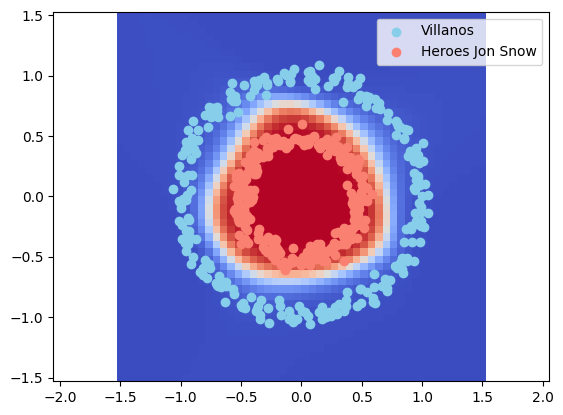

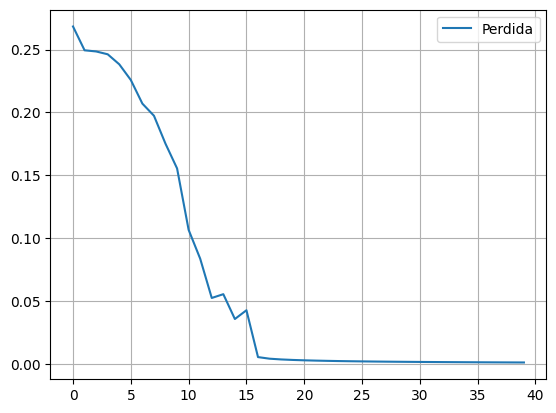

In [7]:
from IPython.display import clear_output
import time

# funcion de activacion y su derivada
sigm = (lambda x: 1/(1+np.e**(-x)),
        lambda x: x *(1 - x))

# funcion de costo y su derivada
funcion_costo = (lambda Yp, Yr : np.mean((Yr - Yp)**2),
                  lambda Yp, Yr : (Yp - Yr))

# numero de muestras
n = 500
# tipo de datos
p = 2

# x=coordeadas, y=valores (aliado o enemigo)
x, y = make_circles(n_samples=n, factor=0.5, noise=0.05)
y = y[:, np.newaxis]

# topologia de la red
topologia = [p, 4, 8, 1]

# creamos un objeto de tipo RedNeuronal
red = RedNeuronal(topologia, sigm)

# para imprimir la funcion de costos
perdida = []

# ciclo de entrenamiento, deberia estar en RedNeuronal
for i in range(1000):
    # se entrena la red 1 vez por ciclo
    py = red.entrenamiento(x, y, funcion_costo, aprendizaje=0.05)
    # una vez entrenada se muestran los valores y se evalua el resultado
    if i % 25 == 0:
        perdida.append(funcion_costo[0](py, y))
        res = 50

        _x0 = np.linspace(-1.5, 1.5, res)
        _x1 = np.linspace(-1.5, 1.5, res)
        _y = np.zeros((res, res))

        # _y nos dice que tan bien o mal va la red
        for i0, x0 in enumerate(_x0):
            for i1, x1 in enumerate(_x1):
                _y[i0, i1] = red.entrenamiento(np.array([[x0, x1]]), y,
                                funcion_costo, entrenar=False)[0][0]

        plt.pcolormesh(_x0, _x1, _y, cmap="coolwarm")
        plt.axis("equal")
        plt.scatter(x[y[:,0]==0 ,0], x[y[:,0]==0 ,1], c='skyblue', label="Villanos")
        plt.scatter(x[y[:,0]==1, 0], x[y[:,0]==1 ,1], c='salmon', label="Heroes Jon Snow")
        clear_output(wait=True)
        plt.legend()
        plt.show()

        plt.plot(range(len(perdida)), perdida, label="Perdida")
        plt.legend()
        plt.grid()
        plt.show()
        time.sleep(0.5)

## Interpretación

Bueno una vez que la red ya fue entrenada y que ambas gráficas de la celda anterior nos muestran como disminuye el error y como se logra clasificar un conjunto de datos, ¿qué podemos decir al respecto?.

*   En este momento la red es completamente capaz de **indentificar si un par de coordenadas corresponde a un aliado o a un enemigo**.
*   El proceso se realizó de manera automatizada y podémos estar seguros que **si cambiamos los datos de entrenamiento la red tratará de adaptarse a estos cambios**.

Veamos que nos devuelve la red, respecto a un par de coordenadas.

In [ ]:
individuo = red.entrenamiento((0,0), entrenar=False)
print(individuo) #aliado

individuo = red.entrenamiento((0.25,0.25), entrenar=False)
print(individuo) #aliado

individuo = red.entrenamiento((5,5), entrenar=False)
print(individuo) #enemigo

individuo = red.entrenamiento((10,10), entrenar=False)
print(individuo) #enemigo

[[0.99954676]]
[[0.99864643]]
[[4.43474524e-08]]
[[4.37087798e-08]]


Tal como se muestra en la celda superior, pares de coordenadas cercanas al origen corresponden a aliados, mientras que pares de coordenadas cuya **norma euclidiana** (módulo), sea mayor o igual a $1.060$ (limite del permímetro de los aliados), tiene una mayor probabilidad de pertenecer a un enemigo.

$$\left\Vert \vec{x}\right\Vert _{2}=\left[\sum_{i=1}^{2}\left|x_{i}\right|^{2}\right]^{1/2}=\sqrt{\left|x_{1}\right|^{2}+\left|x_{2}\right|^{2}}=\sqrt{\left|0.75\right|^{2}+\left|0.75\right|^{2}}=\sqrt{0.5625}=1.060$$

De tal manera que los 2 primeros pares de coordenadas $(0,0)$ y $(0.25, 0.25)$ corresponden aliados, mientras que las 2 últimas coorresponden a enemigos.

# Observaciones

Mucho del proceso que nos lleva a obtener una red neuronal completamente funcional tiene que ver con **estadística** y con el proceso de **prueba y error**.

Por ejemplo la decisión de la topología de la red, la elección de la función de activación y de la tasa de aprendizaje se realizo mediante prueba y error hasta encontrar los parámetros de la red que mostráron un buen resultado.

Gran parte del código e ideas que se muestran en este *jupyter* fueron tomadas de este [video](https://www.youtube.com/watch?v=W8AeOXa_FqU&list=PLo8YL3HL50lUSfq2CdgAhvWVQfxkLHdw2&index=5), te sugiero lo veas para que tengas una mejor compresión del proceso de construcción y configuración de esta red neuronal.

De igual forma como se sugiere en el video, se queda de tarea probar:

*   **Nubes de datos distintas**.
*   **Más tipos de clasificaciones**.
*   **Topologías diferentes**.
*   **Distintas funciones de activación**, etc.

# Conclusiones

Las redes neuronales nos ayudan a encontrar soluciones a 2 tipos principales de problemas (regresión o predicción y clasificación)

En inteligencia artificial, la diferencia entre un problema de clasificación y uno de regresión radica en el tipo de variable que se quiere predecir. La regresión tiene como objetivo predecir valores continuos, mientras que la clasificación tiene como tarea asignar una clase a un conjunto de datos, es decir, predecir a qué clase pertenece un conjunto de datos. En los problemas de clasificación, los valores son discretos 1.

Por ejemplo, si queremos predecir el precio de una casa en función de sus características (metros cuadrados, cantidad de baños, etc.), estaríamos ante un problema de regresión ya que el precio es un valor continuo. Por otro lado, si queremos predecir si una imagen contiene un perro o un gato, estaríamos ante un problema de clasificación ya que la variable a predecir es categórica (perro o gato)

Ya solo resta que continues aprendiendo como funcionan estas herramientas y las utilices para resolver problemas reales. Prueba este [simulador](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.66351&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) y pon cara de asombro, rompelo no te preocupes tal como dicen sus creadores.



# Referencias

*   [Lista de videos redes neuronales (de brothers)](https://www.youtube.com/playlist?list=PLo8YL3HL50lUSfq2CdgAhvWVQfxkLHdw2).
*   [Lista de videos redes neuronales (más formal) ](https://www.youtube.com/playlist?list=PLo8YL3HL50lUHQS80oE_ypxFi0Y3uCVal).